# Preliminary Regen Solver

### Import libraries

In [648]:
# general
import os
import numpy as np
import pandas as pd

# thermo and prop
import cantera as ct
from CoolProp.CoolProp import PropsSI

# numerical methods
import scipy.optimize

# visualization / other
import matplotlib.pyplot as plt

### Manage Directories

In [649]:
plotfolder = "solverplots/"
solvedplotfolder = plotfolder + "solved/"
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)
if not os.path.exists(solvedplotfolder):
    os.mkdir(solvedplotfolder)

## Main parameter defintions
We define all the main parameters below. The definition of these parameters has been localized to this section so that it's easier to work with the code (<em>tune the parameters</em>) and also because it gives a better overview of all the parameters that we can change. These parameters are:
- $P_0$ - Chamber Gas Stagnation (Inlet) Pressure (First Guess)
- $T_i$ - Chamber Gas Inlet Temperature (First Guess)
- $P_{ci}$ - Coolant Inlet Pressure
- $T_{ci}$ - Coolant Inlet Temperature
- $x_{off}$ - Cooling Jacket Starting Point Offset (distance from nozzle end to cooling jacket start)
- $T_{hw}$ - Target Hot Wall Temperature
- $T_{cw}$ - Target Cold Wall Temperature
- $N_{chan}$ - Number of Cooling Channels
- $t_{rib}$ - Thickness of Ribs 
- $k_{wall}$ - Wall Thermal Conductivity
- $N$ - Number of Nodes Used in Solver

In [650]:
def_P0 = 2.758e+6 # [Pa] - first chamber (stagnation) pressure guess 
def_Ti = 300      # [K] - first chamber inlet temperature guess 
def_T_ci = 300 # [K] - coolant inlet temperature
def_P_ci = 4e+6 # [Pa] - coolant inlet pressure
def_x_off = 0.024 # [m] - cooling jacket offset
def_T_hw = 1000 # [K] - target hot wall temperature (should be below 1373 K)
def_T_cw = 500 # [K] - target cold wall temperature (should be below 623 K)
def_N_channels = 15 # [-] - number of cooling channels
def_t_rib = 0.0075 # [m] thickness of ribs 
def_k_wall = 30 # [W/mK] - thermal conductivity of wall
def_N = 100 # number of nodes

### Retrieve Chamber Geometry
Engine Geometry is defined as a function of axial position:
- r(x) - radius of chamber
- th(x) - thickness of chamber wall

The r(x) is retrieved from the engine sizing file (<em>run this file if you haven't yet to create $enginegeometry.csv$ file</em>). Note that th(x) is essentially an initial guess for the thickness (<em>purely for vizualization</em>) as we solve for the wall thickness later.<br>

Additional Geometry Parameters such as throat area $A_t$ and throat axial position $x_t$ are also retrieved.

In [651]:
# read geometry csv file to pandas
df = pd.read_csv("enginefiles/enginegeometry.csv", sep=",")

# extract geometry 
x = df["x [m]"].to_list()
r = df["r [m]"].to_list()

# read parameter csv file to pandas
df = pd.read_csv("enginefiles/engineparameters.csv", sep=",")

# extract geometry parameters
A_t = df["A_t [m^2]"].to_list()[0]
A_e = df["A_e [m^2]"].to_list()[0]
A_c = df["A_c [m^2]"].to_list()[0]
x_c = df["x_c [m]"].to_list()[0]
x_t = df["x_t [m]"].to_list()[0]

# read mass flow csv file to pandas
df = pd.read_csv("enginefiles/enginemassflow.csv", sep=",")

# extract mass flow parameters
OF = df["OF used [-]"].to_list()[0] # OF ratio used in engine sizing
o_mdot = df["o_mdot [kg/s]"].to_list()[0] # oxidizer mass flow rate [kg/s]
f_mdot = df["f_mdot [kg/s]"].to_list()[0] # fuel mass flow rate [kg/s] 

print("x:", x, "\nr:", r, "\nA_t:", A_t, "\nx_t:", x_t, "\nA_e:", A_e, "\nA_c:", A_c, "\nx_c:", x_c, "\no_mdot:", o_mdot, "\nf_mdot:", f_mdot)

x: [0.0, 0.1563740264142062, 0.2337635021500966, 0.3068672185429917] 
r: [0.0635, 0.0635, 0.0188191653514396, 0.0384072471226297] 
A_t: 0.0011126295471713 
x_t: 0.2337637350150275 
A_e: 0.0046342155728302 
A_c: 0.0126676869774374 
x_c: 0.1563742743698348 
o_mdot: 1.798325085687142 
f_mdot: 0.1763063809497198


### Using Cantera to Find Exhaust Gas Properties in Chamber

In [652]:
P0 = def_P0 # First Chamber (Stagnation) Pressure Guess [Pa]
Ti = def_Ti # First Chamber Inlet Temperature Guess [K]

In [653]:
# Define gas
gas = ct.Solution('gri30.yaml')          
mixture = "C2H6:1, N2O:{}".format(OF)    # define mixture via mixture string
gas.TPY = Ti, P0, mixture              # define state of gas before chemical balance
gas.equilibrate("HP")                  # equilibrate keeping enthalpy and pressure constant

# Extract Preliminary Gas Properties
h0 = gas.h  # gas enthalpy [J]
T0 = gas.T  # stagnation temperature [K]
kc = gas.cp / gas.cv # specific heat ratio in chamber
MW = gas.mean_molecular_weight # average molecular weight of gas [kg / kmol]
mu0 = gas.viscosity # dynamic viscosity [Pa s]

# Print Properties
print("Enthalpy:", h0, "[J]\nStagnation temperature:", T0, "[K]\nSpecific heat ratio:", kc, "[-]\nMean molecular weight:", MW, "[kg/kmol]")

Enthalpy: 1441245.9601456434 [J]
Stagnation temperature: 3281.188239511196 [K]
Specific heat ratio: 1.2405024045277944 [-]
Mean molecular weight: 26.203541670258993 [kg/kmol]


### Defining Coolant Inital State
To define coolant initial state we define:
- $T_{ci}$ - coolant inlet temperature
- $P_{ci}$ - coolant inlet pressure

In [654]:
T_ci = def_T_ci # [K] - coolant inlet temperature
P_ci = def_P_ci # [Pa] - coolant inlet pressure 

#### Set Cooling Jacket Start Position
We likely will not have the cooling jacket run over the entire nozzle - therefore we need to set the start position of the cooling jacket (the last $x$ coordinate of the cooling jacket $x_{f}$).

In [655]:
x_f = max(x) - def_x_off # [m] - coordinate of cooling jacket end

print("x_f:", x_f)

x_f: 0.2828672185429917


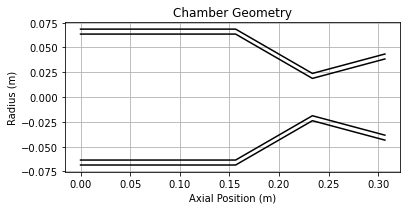

In [656]:
# define function for thickness of chamber wall th(x)

# Note: Currently Using Constant Thickness
const_thickness = 0.005 # [m]
def variable_thickness(x):
    return const_thickness
th = np.array([variable_thickness(_x) for _x in x ]) # thickness of chamber wall [m] 
    

# plot chamber geometry
fig, axs = plt.subplots()
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Chamber Geometry")
axs.set_aspect('equal')
plt.savefig(plotfolder + "enginegeometry.png", dpi=300)


### Define Wall Properties
The main wall property to define is the wall thermal conductivity $k_{wall}$. (<em>Note: Thermal Conductivity is a Function of Temperature - if using a constant value for $k$ - need to use some averaged value.)</em>

In [657]:
k_wall = def_k_wall # [W / m K] - very approximate thermal conductivity of Inconel chamber wall

### Define Injector Geometry

In [658]:
""" PLACEHOLDER CODE """
Ao = 0 # total cross sectional area of orifice [m^2]

## Defining Equations and Functions Used

### Defining Exhaust Gas and Coolant Transport Property Functions
Below we define various functions used to retrieve transport properties for the exhaust gases and coolant (<em>using known temperature $T$ and pressure $P$ values, as well as Mach number $M$ along the chamber</em>).

#### Define Exhaust Gas Properties

In [659]:
# define exhaust gas transport properties - using Cantera
def cp_exhaust(T, p):
    gas.TP = T, p
    return gas.cp # [J/kg K]

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity # [Pa s]

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number

def rho_exhaust(T, p):
    gas.TP = T, p
    return gas.density # [kg/m^3]

def free_vel_exhaust(T, p, M):
    gas.TP = T, p
    return gas.sound_speed * M # [m/s]

#### Define Coolant Transport Properties
For properties not available on CoolProp (<em>$k$, $\mu$, $Pr$</em>) estimates are obtained from:
- [This Paper](https://www.mdpi.com/2226-4310/9/12/828) 

They were obtained as:
- $\mu \approx 1e-4 \, Pa \cdot s$ (conservative estimate taken for saturated liquid) - <b>results are very sensitive to $\mu$</b>
- $k \approx 0.075 \, W / m \cdot K$ (estimate taken roughly between liquid and vapor saturated phases)

In [660]:
# define coolant transport properties - using CoolProp
coolant_name = 'NITROUSOXIDE'

''''Placeholder Values for Coolant Properties'''
def rho_coolant_Q0_P(P):
    return PropsSI('DMASS','P', P, 'Q', 0, coolant_name)

def cp_coolant_Q0_P(P):
    return PropsSI('CPMASS','P', P, 'Q', 0, coolant_name)

k_coolant = 0.075 # [W / m K] - thermal conductivity of nitrous oxide at 300 K
mu_coolant = 1e-4 # [Pa s] - dynamic viscosity of nitrous oxide at 300 K

def Pr_coolant_Q0_P(P):
    return cp_coolant_Q0_P(P) * mu_coolant / k_coolant # Prandtl number of nitrous oxide at 300 K

print("Prandtl number of nitrous oxide at 400 psi:", Pr_coolant_Q0_P(400*6894.76))

Prandtl number of nitrous oxide at 400 psi: 2.907126240760482


### Defining Heat Transfer Rate and Thermal Resistance Functions

In [661]:
# film coefficient functions
def h_gas_bartz(D, cp, mu, Pr, rho, v, rho_am, mu_am, mu0):
    """
    Bartz equation, using Equation (8-23) from page 312 of RPE 7th edition (Reference [1]). 'am' refers to the gas being at the 'arithmetic mean' of the wall and freestream temperatures.

    Args:
        D (float): Gas flow diameter (m)
        cp_inf (float): Specific heat capacity at constant pressure for the gas, in the freestream
        mu_inf (float): Absolute viscosity in the freestream
        Pr_inf (float): Prandtl number in the freestream
        rho_inf (float): Density of the gas in the freestream
        v_inf (float): Velocity of the gas in in the freestream
        rho_am (float): Density of the gas, at T = (T_wall + T_freestream)/2, P - exhaust static pressure
        mu_am (float): Absolute viscosity of the gas, at T = (T_wall + T_freestream)/2, P - exhaust static pressure
        mu0 (float): Absolute viscosity of the gas under stagnation conditions.
        
    Returns:
        float: Convective heat transfer coefficient (W/m2/K), h, for the exhaust gas side (where q = h(T - T_inf)).
    """

    return (0.026/D**0.2) * (cp*mu**0.2)/(Pr**0.6) * (rho * v)**0.8 * (rho_am/rho) * (mu_am/mu0)**0.2

def h_coolant_dittus_boelter(rho, v, Dh, mu, Pr, k):
    """Dittus-Boelter equation for convective heat transfer coefficient.

    Args:
        rho (float): Coolant bulk density (kg/m^3).
        V (float): Coolant bulk velocity (m/s)
        D (float): Hydraulic diameter of pipe (m)
        mu (float): Coolant bulk viscosity (Pa s)
        Pr (float): Coolant bulk Prandtl number
        k (float): Coolant thermal conductivity

    Returns:
        float: Convective heat transfer coefficient (W/m2/K)
    """
    Re = rho*v*Dh/mu
    Nu = 0.023*Re**(4/5)*Pr**0.4

    return Nu*k/Dh

# thermal resistance functions for a dx slice 
def R_wall(r, th, k_wall, dx):
    """Thermal resistance of a wall of inner radius r, thickness th, thermal conductivity k, slice width dx.

    Args:
        r (float): Radius (m)
        th (float): Wall thickness (m)
        k (float): Thermal conductivity (W/m/K)

    Returns:
        float: Thermal resistance for wall (K/W)
    """

    return np.log((r + th)/r)/(2*np.pi*k_wall*dx)

def R_convective(r, h, dx): # used for both coolant and exhaust gas
    """Thermal resistance of a convective boundary layer of slice length dx and convective heat transfer coefficient h.

    Args:
        r (float): Local radius of the surface at which convection occurs (m)
        h (float): Convective heat transfer coefficient (W/m2/K)
        dx (float): Boundary layer slice length (m)

    Returns:
        float: Thermal resistance for convective boundary layer (K/W)
    """

    return 1/(2*np.pi*h*r*dx)   

### Defining Other Useful Functions

In [662]:
def Dh_rectangular(w, h):
    """Hydraulic diameter of a rectangular channel.

    Args:
        w (float): Width of channel (m)
        h (float): Height of channel (m)

    Returns:
        float: Hydraulic diameter of channel (m)
    """
    return 2*w*h/(w+h)
def dp_darcy_weisbach(f_D, rho, v, Dh, drdx, dx):
    """Darcy-Weisbach equation for pressure drop in a pipe.

    Args:
        f_D (float): Darcy friction factor
        rho (float): Density of fluid (kg/m^3)
        v (float): Velocity of fluid (m/s)
        Dh (float): Hydraulic diameter of pipe (m)

    Returns:
        float: Pressure drop (Pa)
    """
    return f_D*rho*(v**2) / (2*Dh) * np.sqrt(drdx**2 + 1) * dx

def reynolds(Dh, v, rho, mu):
    """Reynolds number for a pipe.

    Args:
        Dh (float): Hydraulic diameter of pipe (m)
        v (float): Velocity of fluid (m/s)
        rho (float): Density of fluid (kg/m^3)
        mu (float): Dynamic viscosity of fluid (Pa s)

    Returns:
        float: Reynolds number
    """
    return rho*v*Dh/mu

### Discretize Engine into N Slices
To run the solver we must slice our engine into discrete section - reffered to as nodes from here on out. 

Each node has the following properties associated with it:
- $x$ - axial position of node
- $r$ - a radius of the chamber at that node
- $\frac{dr}{dx}$ - slope of channel walls at node
- $A$ - the cross sectional area of the chamber at that node
- $M$ - Mach number at that node of exhaust gas
- $T$ - temperature of exhaust gas at node
- $P$ - pressure of exhaust gas at node
- $OD$ - chamber wall outer diameter (ignoring cooling jacket)
- $w$ - channel width at node
- $h$ - channel height at node
- $A$ - channel cross sectional area at each node
- $Dh$ - channel hydraulic diameter at each node
- $T_{hw}$ - hot gas side wall temperature (set by user) at node
- $T_{cw}$ - cold wall side temperature at node
- $T_c$ - coolant bulk temperature at node
- $P_c$ - coolant pressure at node
- $v_c$ - coolant velocity at node
- $Re_c$ - coolant Reynolds number at node
- $q$ - steady state heat flow rate per area at node 
- $d\dot{Q}$ - steady state heat flow rate at node slice (saved simply as $Q$ in object)
- $t_w$ - wall thickness at node

In [663]:
# define amount of nodes
N = def_N

# calculate node axial increment
dx = max(x) / N

print("Amount of nodes:", N, "\nAxial increment:", dx * 1000, "mm")

Amount of nodes: 100 
Axial increment: 3.068672185429917 mm


In [664]:
# Define Node Object
class Node:

    # constructor and setters
    def __init__(self):
        self.x = 0
        self.r = 0
        self.drdx = 0
        self.A = 0
        self.M = 0
        self.T = 0
        self.P = 0
        self.OD = 0
        self.w = 0
        self.h = 0
        self.A_c = 0
        self.Dh_c = 0
        self.T_hw = 0
        self.T_cw = 0
        self.T_c = 0
        self.P_c = 0
        self.v_c = 0
        self.Re_c = 0
        self.q = 0
        self.Q = 0
        self.t_w = 0
    
    def set_x(self, x):
        self.x = x
    
    def set_r(self, r):
        self.r = r

        # implicilty calculate area from r
        self.A = np.pi * r**2

    def set_drdx(self, drdx):
        self.drdx = drdx
        
    def set_M(self, M):
        self.M = M

    def set_T(self, T):
        self.T = T

    def set_P(self, P):
        self.P = P

    def set_OD(self, OD):
        self.OD = OD

    def set_w(self, w):
        self.w = w
    
    def set_h(self, h):
        self.h = h
        self.A_c = self.w * self.h # setting height implicitly sets area of coolant channel
        self.Dh_c = Dh_rectangular(self.w, self.h) # setting height implicitly sets hydraulic diameter of coolant channel

    def set_T_hw(self, T_hw):
        self.T_hw = T_hw
    
    def set_T_cw(self, T_cw):
        self.T_cw = T_cw

    def set_T_c(self, T_c):
        self.T_c = T_c

    def set_P_c(self, P_c):
        self.P_c = P_c

    def set_v_c(self, v_c):
        self.v_c = v_c
    
    def set_Re_c(self, Re_c):
        self.Re_c = Re_c

    def set_q(self, q):
        self.q = q

    def set_Q(self, Q):
        self.Q = Q

    def set_t_w(self, t_w):
        self.t_w = t_w

    # special methods
    def print_coolant_parameters(self):
        # Define the headers for the table
        headers = ["Parameter", "Value"]

        # Define the data for the table
        data = [
            ("Axial Position (x)", self.x),
            ("Channel Width (w)", self.w),
            ("Channel Height (h)", self.h),
            ("Coolant Bulk Temperature (T_c)", self.T_c),
            ("Coolant Pressure (P_c)", self.P_c),
            ("Coolant Velocity (v_c)", self.v_c),
            ("Heat Flow through Walls (Q)", self.Q),
            ("Temperature Drop along Wall (T_hw-T_cw)", self.T_hw - self.T_cw),
            ("Wall Thickness (t_w)", self.t_w)
        ]

        # Call the helper method to print the table
        self._print_table(headers, data)

    # Helper method to print the table
    def _print_table(self, headers, data):
        # Calculate the maximum width for each column
        max_widths = [max(len(str(item)) for item in column) for column in zip(headers, *data)]

        # Print the headers
        print(" | ".join(f"{header:<{width}}" for header, width in zip(headers, max_widths)))

        # Print the separator line
        print("-" * (sum(max_widths) + len(headers) * 3 - 1))

        # Print the data rows
        for row in data:
            print(" | ".join(f"{item:<{width}}" for item, width in zip(row, max_widths)))


To freely discretize the geometry of the chamber we must find some functional form of expressing the geometry. Since our chamber is linear - we will just fit various straight line segments between the given geometry points.

In [665]:
# finding x positons for various pairs of points
points12x = x[:2] # points 1 and 2
points23x = x[1:3] # points 2 and 3
points34x = x[2:4] # points 3 and 4

# finding r positons for various pairs of points
points12r = r[:2] # points 1 and 2
points23r = r[1:3] # points 2 and 3
points34r = r[2:4] # points 3 and 4

# finding slopes and intercepts for various pairs of points
slope12, intercept12 = np.polyfit(points12x, points12r, 1) # points 1 and 2
slope23, intercept23 = np.polyfit(points23x, points23r, 1) # points 2 and 3
slope34, intercept34 = np.polyfit(points34x, points34r, 1) # points 3 and 4

# print all linear equations obtained
print("r = {}x + {}".format(slope12, intercept12))
print("r = {}x + {}".format(slope23, intercept23))
print("r = {}x + {}".format(slope34, intercept34))


r = -1.3312109554934719e-16x + 0.06349999999999999
r = -0.5773502691896264x + 0.1537825862445077
r = 0.267949192431123x + -0.04381757626954981


Find node axial positons, radii, and wall outer diameters.

In [666]:
x_n = np.linspace(x[0], x[-1], N) # x positions of nodes
r_n = np.zeros_like(x_n) # r positions of nodes
OD_n = np.zeros_like(x_n) # outer diameter of chamber wall of nodes
drdx_n = np.zeros_like(x_n) # slope of channel walls at nodes

for i, el in enumerate(x_n):
    slope = 0
    # find r_n
    if el <= x[1]:
        node_r_n = slope12 * el + intercept12
        # note: for interval 1-2 slope is 0
    elif el <= x[2]:
        node_r_n = slope23 * el + intercept23
        slope = slope23
    else:
        node_r_n = slope34 * el + intercept34
        slope = slope34

    # set r_n
    r_n[i] = node_r_n

    # set wallOD
    OD_n[i] = 2 * (node_r_n + variable_thickness(el))

    # set slope
    drdx_n[i] = slope

# print results
print("Slopes of channel walls at nodes:", drdx_n)

Slopes of channel walls at nodes: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.57735027 -0.57735027 -0.57735027
 -0.57735027 -0.57735027 -0.57735027 -0.57735027 -0.57735027 -0.57735027
 -0.57735027 -0.57735027 -0.57735027 -0.57735027 -0.57735027 -0.57735027
 -0.57735027 -0.57735027 -0.57735027 -0.57735027 -0.57735027 -0.57735027
 -0.57735027 -0.57735027 -0.57735027 -0.57735027  0.26794919  0.26794919
  0.26794919  0.26794919  0.26794919  0.26794919  0.26794919  0.26794919
  0.2679

### Creating Node List
To work with each node we can store them in an array (of size $N$).

In [667]:
# create size N array of Nodes
nodes = np.empty(N, dtype=Node)

# set x and r values of each node
for i, el in enumerate(nodes):
    el = Node()
    el.set_x(x_n[i])
    el.set_r(r_n[i])
    el.set_OD(OD_n[i])
    el.set_drdx(drdx_n[i])
    nodes[i] = el


### Solving Exhaust Gas State at Each Slice
To solve the exhaust gas state at each slice we can use the isentropic flow equations for $T$ and $P$, i.e. $T = T_0(1+\frac{k-1}{2}M^2)^{-1}$ and $p=p_0(1+\frac{k-1}{2}M^2)^{\frac{-k}{k-1}}$.<br>

But as is apparent, to do so we must first find the Mach number $M$ at each axial position of the chamber.

One potential method to do this is to use the formula for nozzle area ratio in terms of Mach number. If we look at the nozzle area ratio with the throat area $r_A = \frac{A}{A_t}$ using the fact that at the throat $M = 1$ we get the expression $r_A(M) = \frac{A}{A_t} = \frac{1}{M}(\frac{2+(k-1)M^2}{k+1})^{\frac{k+1}{2(k-1)}}$. This relates the area $A$ at any axial section to the Mach number $M$.

However, solving such an equation for Mach number $M$ given area $A$ directly is difficult, therefore we would need to use a numerical solution method (<em>such as the $root\_ scalar()$ method offered by scipy</em>).


### Finding Mach Number $M$ at Each Slice
If we try to solve for $M$ from the relation $r_A(M)$, we will get 2 solutions given a certain $A$ (<em>this is illustrated graphically in Appenidx A lower below</em>). These 2 solutions correspond accordingly to subsonic flow and supersonic flow (<em>i.e. if we just give an area $A$ and try to find the $M$ from the equation $r_A(M)$ we would get 2 Mach number $M$ values - one $M_{conv}$ if the area $A$ would be in the convergent section and one $M_{div}$ if the area would be in the divergent section </em>).

Therefore we have to separate the subsonic flow and supersonic flow cases.

In [668]:
# express r_A as a function of k and M
def A_At(M, k):
    return 1/M * ( (2 + (k-1) * M**2) / (k + 1) )**( (k+1) / (2 * (k-1) ) )

# define function to find M when flow is subsonic
def get_M_subsonic(A, A_t, kc):
    # define function to give give the numerical solver
    def func_to_solve(M): # here Mach number M is the "x" variable we want scipy.optimize.root to solve for - we want to find the coordinatate of x such that the function is zero i.e. the root
        return  A/A_t - A_At(M, kc) # we want to minimize the difference / find the root (when the difference is zero)
    
    return scipy.optimize.root_scalar(func_to_solve, bracket = [1e-5, 1], x0 = 0.5).root # the bracket is the range of values to search for the root, x0 is the initial guess

def get_M_supersonic(A, A_t, kc):
    # define function to give give the numerical solver
    def func_to_solve(M): # here Mach number M is the "x" variable we want scipy.optimize.root to solve for - we want to find the coordinatate of x such that the function is zero i.e. the root
        return  A/A_t - A_At(M, kc) # we want to minimize the difference / find the root (when the difference is zero)
    
    return scipy.optimize.root_scalar(func_to_solve, bracket = [1, 500], x0 = 1).root # the bracket is the range of values to search for the root, x0 is the initial guess

# print Mach number at exit area (supersonic) as a test
print("Mach number at exit area:", get_M_supersonic(A_e, A_t, kc))
print("Mach number at throat:", get_M_subsonic(A_t, A_t, kc))
print("Mach number at nozzle inlet:", get_M_subsonic(A_c, A_t, kc))

Mach number at exit area: 2.7135457606566735
Mach number at throat: 1.0
Mach number at nozzle inlet: 0.05183192198425061


Below we find the Mach number at each node. Note that in our model, we assume the nozzle inlet velocity $v_1 = 0$ and that the gas velocity throughout the entire cylindrical section is also $v = 0$. However, of course this is an imperfect approximation and as soon as we estimate the Mach number $M$ at the nozzle inlet we will obtain a nonzero value and a nonzero $v_1$. Since the velocity $v$ at each node is tied to the heat flow rate $Q$ (<em>calculated later</em>) setting a velocity $v = 0$ at any node would result heat flow rate $Q = 0$ at that node.

To prevent this - in our approach we currently model the gas velocity throughout the chamber as being $v_1$ - the velocity at the nozzle inlet. (<em>Simply put, we model the conditions at any node in the cylindrical section to be the same as those at the nozzle inlet node.</em>) If we would not use this estimation, we would experience a discontinuous jump from 0 in some modeled gas properties at the nozzle inlet node.

In [669]:
# find Mach number at each node
for node in nodes:
    if node.x < x_c:
        node.set_M(get_M_subsonic(A_c, A_t, kc)) # if node is in chamber cylindrical section use approximation that M cylindrical is M at nozzle inlet
    elif node.x < x_t:
        node.set_M(get_M_subsonic(node.A, A_t, kc)) # if node is in convergent section, M is subsonic
    else:
        node.set_M(get_M_supersonic(node.A, A_t, kc)) # if node is in divergent section, M is supersonic

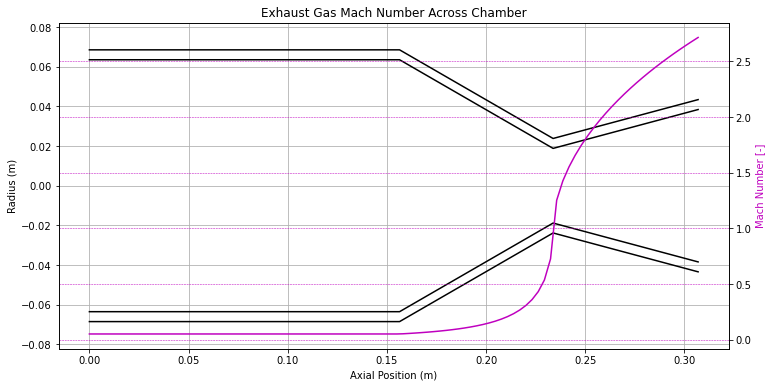

In [670]:
# plot Mach number at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Mach Number Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "m", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.M for node in nodes], color = "m")
axs2.set_ylabel("Mach Number [-]", color = "m")
plt.savefig(plotfolder + "machvsenginegeometry.png", dpi=300)
plt.show()

### Finding Temperature $T$ and Pressure $P$ of Gas at Each Node
To find $T$ and $P$ we use the Mach number at each node and the isentropic equations listed before.

In [671]:
# defining isentropic flow equations for static T and P of exhaust gas given M, kc, T0, and P0
def isen_T(M, kc, T0):
    return T0*(1 + ((kc - 1)/2) * M**2)**(-1)

def isen_P(M, kc, P0):
    return P0*(1 + ((kc - 1)/2) * M**2)**((-kc)/(kc - 1))

In [672]:
# populate nodes array with T and P values - find temperature and pressue at each node
for node in nodes:
    if node.M == 0:  # set T and P to stagnation values if node is in chamber
        node.set_T(T0)
        node.set_P(P0)
    else:
        node.set_T(isen_T(node.M, kc, T0))
        node.set_P(isen_P(node.M, kc, P0))

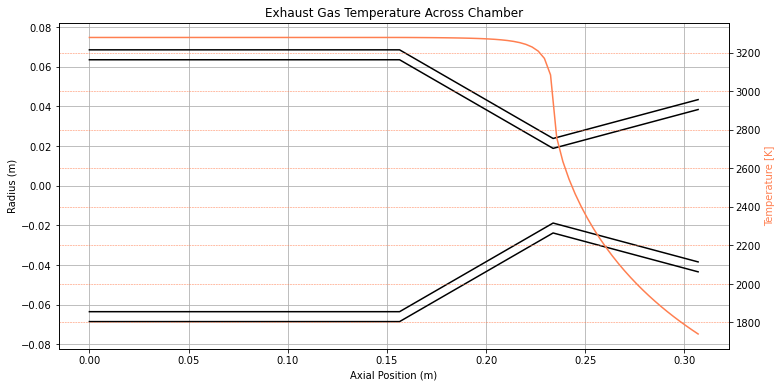

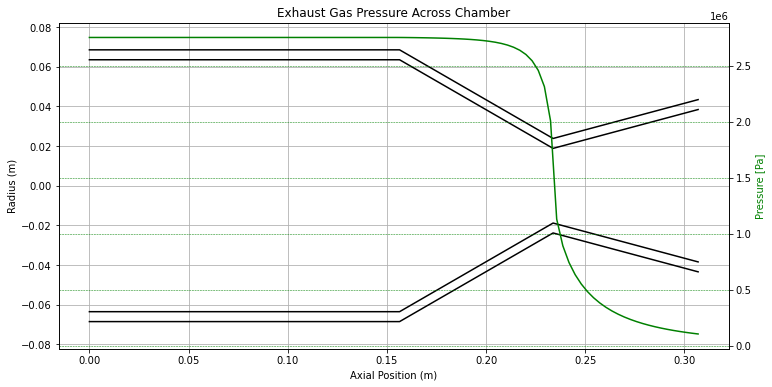

In [673]:
# plot Temperature at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Temperature Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "coral", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.T for node in nodes], color = "coral")
axs2.set_ylabel("Temperature [K]", color = "coral")
plt.savefig(plotfolder + "tempvsenginegeometry.png", dpi=300)
plt.show()

# plot Pressure at each node
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Exhaust Gas Pressure Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "g", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.P for node in nodes], color = "g")
axs2.set_ylabel("Pressure [Pa]", color = "g")
plt.savefig(plotfolder + "presvsenginegeometry.png", dpi=300)
plt.show()

### Separate Cooling Jacket Nodes
From now on - to analyze the cooling jacket nodes we will separate the nodes of the cooling jacket into a separate list (<em>that is still linked to the full nodes list</em>).

In [674]:
# find position of last node of cooling jacket
i_f = 0
for i, node in enumerate(nodes):
    if node.x > x_f:
        i_f = i - 1 # if this node is larger than the final position, then the previous node is the last node of the cooling jacket
        break
    elif node.x == x_f:
        i_f = i # if this node is equal to the final position, then this node is the last node of the cooling jacket
        break

nodesc = nodes[:i_f+1] # cooling jacket nodes (i_f + 1 is not included)

print("Number of nodes:", len(nodes), "\nNumber of cooling jacket nodes:", len(nodesc), "\nLast cooling jacket node index:", i_f)

Number of nodes: 100 
Number of cooling jacket nodes: 92 
Last cooling jacket node index: 91


### Defining Target Chamber Wall Temperature
In this section we define the target chamber wall temperature $T_{hw}$ at each node. The values defined here will be the assumed (<em>target</em>) values for the hot wall temperature. From this, we will calculate the steady state heat flux at every node and which will be used for calculating the temperatures at the various layers of the chamber at each node.<br>

For Inconel - we wish to keep the hot wall temperature below $\approx 1373$ K at each node.

In [675]:
# define function T(x) to define target temperature of hot wall at each node
T_hw_constant = def_T_hw # [K]
def T_hw(x):
    return T_hw_constant # for now, just define a constant temperature

# populate nodes with target hot wall temperatures
for node in nodes:
    node.set_T_hw(T_hw(node.x))

### Defining Target Coolant Wall Temperature
In this section we define the target coolant wall temperature $T_{cw}$ at each node. The values defined here will be the target values for the coolant cold wall temperature. We will calculate the necessary wall thickness at each node to reach said coolant wall temperatures.

For Nitrous, our maximum upper limit for the cold wall temperature is $\approx 623 K$.

In [676]:
# define function T(x) to define target temperature of cold wall at each node
T_cw_constant = def_T_cw # [K]
def T_cw(x):
    return T_cw_constant # for now, just define a constant temperature

# populate nodes with target cold wall temperatures
for node in nodes:
    node.set_T_cw(T_cw(node.x))

### Defining Cooling Jacket Geometry Constraints
In the following section our goal is to determine the cooling jacket geometry, specifically the width of the coolant channels at each axial position (node). We constrain the geometry by setting the following variables:
- N_channels - number of cooling channels in the jacket
- t_rib - rib thickness

Based on these variables, the outer diameter of the chamber wall is used to create a 2D envelope of the engine outer wall surface. Along this envelope the cooling channels are evenly distributed with a constant rib thickness between them. This means that the width of the channels decreases as the outer diameter of the chamber wall decreases.<br>

Using this cooling jacket geometry, we later solve for the cooling channel height.

In [677]:
# define cooling jacket geometry parameters
N_channels = def_N_channels # number of cooling channels
t_rib = def_t_rib # thickness of ribs [m]

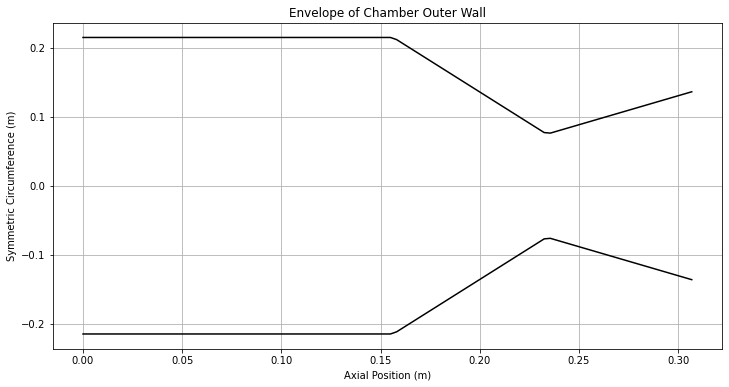

In [678]:
# plot the chamber outer wall envelope
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x_n, (OD_n * np.pi) / 2, color = "k")
axs.plot(x_n, -(OD_n * np.pi) / 2, color = "k")
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Symmetric Circumference (m)")
axs.set_title("Envelope of Chamber Outer Wall")
plt.show()

<b>At every node calculate:</b>  
- $C$ - circumference
- $L_{rt}$ - total length of circumference occupied by ribs
- $w$ - channel width

Channel width $w$ at every node is calculated as the circumference of the chamber ($C = (OD) * \pi$) minus the total rib length $L_{rt}$ divided by the amount of channels.  

(<em>Note that currently we do indeed calculate these paramters for every node - even if it is not a cooling jacket node and that the plots also include these "non-cooling-jacket" nodes.</em>)

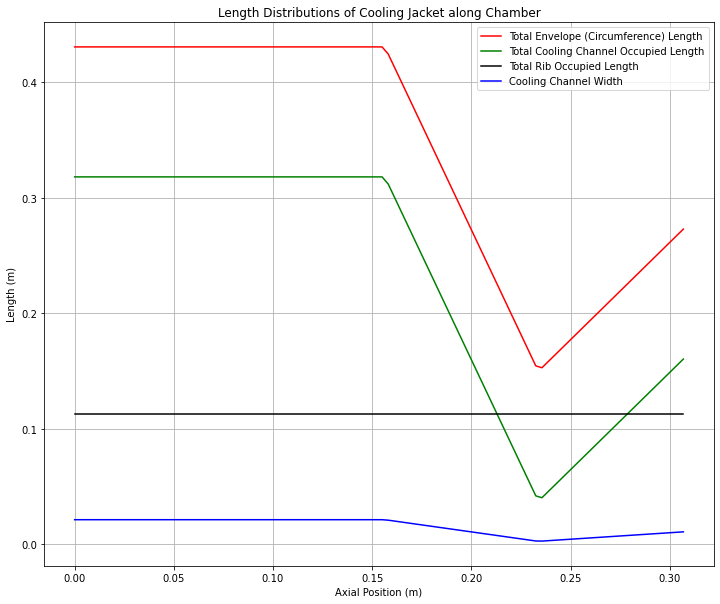

Range of cooling channel width: 2.6806494990726755 to 21.193212902786772 [mm]


In [679]:
# calculate length of ribs at all envelope sections - for N_channels cooling channels there will be N_channels ribs (when counting going around the circumference)
C = np.pi * OD_n # circumference of chamber outer wall at each node
L_rt = [(N_channels) * t_rib for i in range(N)] # total circumference length occupied by ribs at each node
w = (C - L_rt) / N_channels # width of each cooling channel

if min(w) < 0:
    print("ERROR: Cooling channel width is negative at one or more nodes. Please check cooling jacket geometry parameters.")
    
# plot results: length occupied by rib, length occupied by walls and total envelope length (circumference) at each node
fig, axs = plt.subplots(figsize = (12, 10))
fig.set_facecolor('white')
axs.plot(x_n, C, color = "r", label = "Total Envelope (Circumference) Length")
axs.plot(x_n, C - L_rt, color = "g", label = "Total Cooling Channel Occupied Length")
axs.plot(x_n, L_rt, color = "k", label = "Total Rib Occupied Length")
axs.plot(x_n, w, color = "b", label = "Cooling Channel Width")
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Length (m)")
axs.set_title("Length Distributions of Cooling Jacket along Chamber")
axs.legend()
plt.show()

# print results
print("Range of cooling channel width:", min(w) * 1000.0, "to", max(w) * 1000.0, "[mm]")

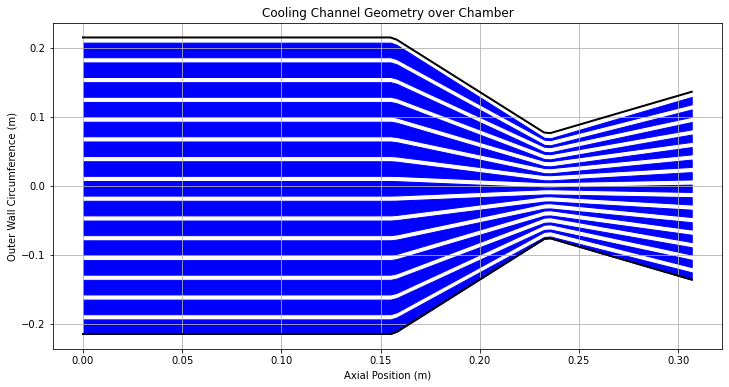

<Figure size 432x288 with 0 Axes>

In [680]:
# visualize channel geometry by plotting channel walls on top of chamber outer wall envelope
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.grid()
# plot chamber envelope
axs.plot(x_n, (OD_n * np.pi) / 2, color = "k", linewidth = 2)
axs.plot(x_n, -(OD_n * np.pi) / 2, color = "k", linewidth = 2)

#axs.fill_between(x_n, (OD_n * np.pi) / 2, -(OD_n * np.pi) / 2, color = "gray") # color in ribs
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Outer Wall Circumference (m)")
axs.set_title("Cooling Channel Geometry over Chamber")
for i in range(N_channels):
    axs.fill_between(x_n, - (OD_n * np.pi) / 2 + i * (t_rib + w), - (OD_n * np.pi) / 2 + i * (t_rib + w) + w, color = "b") # at the x-th position with respective outer diameter OD and channel width w plot the i-th channel
plt.show()
plt.savefig(plotfolder + "coolingchannelenvelope.png", dpi=300)

The main purpose of the cooling jacket geometry definition was to obtain the coolant channel width at every node - which we assign to each node below.

In [681]:
# assign each node the width of the cooling channels at that node
for i, el in enumerate(nodes):
    el.set_w(w[i])

## Iterating Over all Nodes to find Heat Flow, Layer Temperatures and Coolant State 

Because the coolant will flow from nozzle to injector we must first reverse the order of the nodes in our node list.

In [682]:
# reverse order of nodes array
nodes = nodes[::-1]

### Solving for Heat Flow at each Node
To solve for heat flow at each node, we first find the convective heat transfer coefficient $h_g$ for the gas film layer from the Bartz equation $h_g = \frac{0.026}{D^{0.2}}(\frac{c_p \mu^{0.2}}{Pr^{0.6}})(\rho v)^{0.8} (\frac{\rho_{am}}{\rho'})(\frac{\mu_{am}}{\mu_0})^{0.2}$ using the transport properties defined before. <br>

Knowing the heat transfer coefficient $h_g$ we can calculate the heat flow rate (per unit area) $q = h_g (T - T_{hw})$. We can also calculate the heat transfer rate $d\dot{Q}$ at every axial slice (<em>in units \[W\]</em>) as $d\dot{Q} = q dA = q 2 \pi r dx = h_g \Delta T 2 \pi r dx = \frac{\Delta T}{R}$. Where we can see that the <em>Thermal Resistance</em> $R$ for each gas film layer slice (<em>of thickness $dx$</em>) can be found as $R dx = \frac{1}{2 \pi r h}$

We will generally use the thermal resistance approach in the form $Q = \frac{\Delta T}{R}$, where Q is in units \[W\].

In [683]:
# for node 0
Dh = 2 * nodes[0].r # diameter of gas flow at node 0
cp = cp_exhaust(nodes[0].T, nodes[0].P) # specific heat capacity at constant pressure for the gas, in the freestream
mu = mu_exhaust(nodes[0].T, nodes[0].P) # absolute viscosity in the freestream
Pr = Pr_exhaust(nodes[0].T, nodes[0].P) # Prandtl number in the freestream
rho = rho_exhaust(nodes[0].T, nodes[0].P) # density of the gas in the freestream
v = free_vel_exhaust(nodes[0].T, nodes[0].P, nodes[0].M) # velocity of the gas in in the freestream
rho_am = rho_exhaust((nodes[0].T + nodes[0].T_hw) / 2.0, nodes[0].P) # density of the gas, at T = (T_wall + T_freestream)/2
mu_am = mu_exhaust((nodes[0].T + nodes[0].T_hw) / 2.0, nodes[0].P) # absolute viscosity of the gas, at T = (T_wall + T_freestream)/2

# for each node in list calculate h_gas and heat flow rate
for node in nodes:
    Dh = 2 * node.r # diameter of gas flow at node
    cp = cp_exhaust(node.T, node.P) # specific heat capacity at constant pressure for the gas, in the freestream
    mu = mu_exhaust(node.T, node.P) # absolute viscosity in the freestream
    Pr = Pr_exhaust(node.T, node.P) # Prandtl number in the freestream
    rho = rho_exhaust(node.T, node.P) # density of the gas in the freestream
    v = free_vel_exhaust(node.T, node.P, node.M) # velocity of the gas in in the freestream
    rho_am = rho_exhaust((node.T + node.T_hw) / 2.0, node.P) # density of the gas, at T = (T_wall + T_freestream)/2
    mu_am = mu_exhaust((node.T + node.T_hw) / 2.0, node.P) # absolute viscosity of the gas, at T = (T_wall + T_freestream)/2

    # calculate film coefficeint h_gas and heat flow rate per area q
    h_gas = h_gas_bartz(Dh, cp, mu, Pr, rho, v, rho_am, mu_am, mu0) # [W/m^2/K]
    q = h_gas * (node.T - node.T_hw) # [W/m^2]

    # calculate heat flow rate Q at slice
    R_gas = R_convective(node.r, h_gas, dx) # [K/W] - thermal resistance of gas layer slice
    Q = (node.T - node.T_hw) / R_gas # [W]

    # set node values
    node.set_q(q) # [W/m^2]
    node.set_Q(Q) # [W]


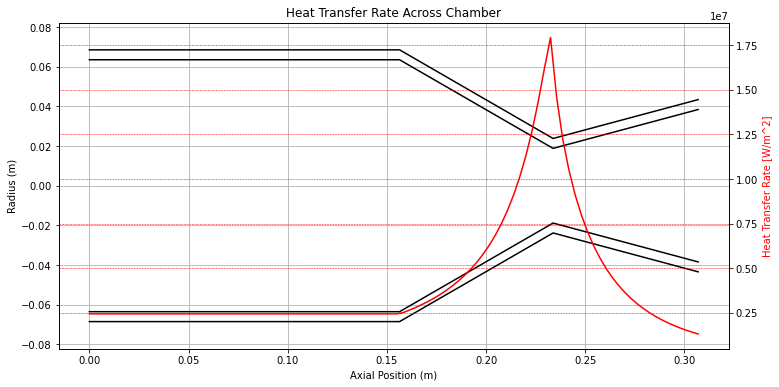

Maximum heat flux: 17.942968077258268 [MW/m^2]


In [684]:
# plot results
# first need to reverse node list back to original order
nodes = nodes[::-1]

fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.plot(x, np.add(r, th), color = "k") # upper outer wall
axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Heat Transfer Rate Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "r", linestyle = "--", linewidth = 0.5)
axs2.plot(x_n, [node.q for node in nodes], color = "r")
axs2.set_ylabel("Heat Transfer Rate [W/m^2]", color = "r")
plt.savefig(plotfolder + "heatvsenginegeometry.png", dpi=300)
plt.show()

# rereverse node list
nodes = nodes[::-1]

# print max heat flux
print("Maximum heat flux:", max([node.q for node in nodes])/1e6, "[MW/m^2]")

### Iterate Through Each Node to Find Thermal Resistance Values at Each $dx$ Slice, Layer Temperatures, and Coolant State
Our general procedure for iterating through the nodes will be:
1. Given heat flow at current node $\dot{Q}$ solve for wall thickness $t_w$ such that coolant-side wall temperature is target temperature $T_{cw}$.
2. Given temperature $T_c$ of coolant and steady state heat flow rate $\dot{Q}$ at current node, solve for thermal resistance $R_c$ <em>(and therefore convective heat transfer coefficient $h_c$)</em> of the coolant film layer. Then iterate on channel height $h$ that produces this calculated resistance $R_c$ (<em>from Dittus Boelter relating velocity $v$ at node to cross sectional area $A$ of channel</em>).
3. Solve for temperature $T_{i+1}$ at <b>next node</b> (<em>from enthalpy conservation assuming all energy is going into changing $T$ of coolant i.e. assuming velocity is only set by wall geometry</em>)
4. Solve for pressure $P_{i+1}$ at <b>next node</b> by solving for pressure drop $\Delta P$ at current node (<em>from Darcy-Weisbach</em>).

#### Start with First Node
To start with the iteration process we must start with determining the state at the first node. For this we need to make some asssumptions - they are the following:
- $T_c = T_{ci}$ - coolant bulk temperature at first node is coolant inlet temperature
- $P_c = P_{ci}$ - coolant pressure at first node is coolant inlet pressure

After making these initial assumptions we will go through the first iteration (<em>for the first node</em>) and define all relevant functions used in the full iteration process.

In [685]:
# reverse cooling jacket node list
nodesc = nodesc[::-1]

# check that first node of cooling jacket is located at end of cooling jacket
print("Node 0 position:", nodesc[0].x)

# make some inital guessees to start iteration process at first node
h_guess = 0.005 # [m] - initial guess for coolant wall height
t_w_guess = const_thickness # [m] - initial guess for wall thickness

# set assumptions for first node
nodesc[0].set_T_c(T_ci) # set coolant temperature at first node to coolant inlet temperature
nodesc[0].set_P_c(P_ci) # set coolant pressure at first node to coolant inlet pressure

# set initial node to node 0
node0 = nodesc[0]

Node 0 position: 0.28206986754961866


#### Solve for wall thickness $t_{w1}$ at first node (Step 1).

In [686]:
# define function to find wall thickness such that necessary temperature drop across wall is achieved
def solve_for_t_w(node):
    def func_to_solve(t_w):
        # find thermal resistance of wall
        R_w = R_wall(node.r, t_w, k_wall, dx) # [K/W]

        # find temperature drop across wall
        delta_T_w = node.Q * R_w # [K]

        # find target temperature drop
        delta_T_w_target = node.T_hw - node.T_cw # [K]

        return delta_T_w - (delta_T_w_target) # we want to minimize the difference / find the root (when the difference is zero)

    # solve for wall thickness
    return scipy.optimize.root_scalar(func_to_solve, bracket = [0.0001, 0.1], x0 = t_w_guess).root # the bracket is the range of values to search for the root, x0 is the initial guess

t_w = solve_for_t_w(node0) # [m] - wall thickness at first node

# add wall thickness to first node
node0.set_t_w(t_w)

# check result validity
print("t_w:", t_w, "[m]\nTemperature drop across wall:", node0.Q * R_wall(node0.r, t_w, k_wall, dx), "[K]")

t_w: 0.006542436735388365 [m]
Temperature drop across wall: 499.99999997544484 [K]


#### Solve for coolant wall height $h_1$ at first node (Step 2). 
To do this we must solve for coolant velocity given a certain $h$ value, which we express from mass flow conservation $\dot{m} = \rho A v$ as $v = \frac{\dot{m}}{\rho w N_{channels}  h}$

But first we will look at some general relations related to coolant velocity $v$ and wall height $h$ - we will analyse the change of convective heat transfer coefficient $h_c$ and therefore thermal resistance of layer $R_c = \frac{1}{2 \pi h_c r dx}$ (<em>inversely proportional to $h_c$</em>) and heat transfer rate $d\dot{Q}=\frac{\Delta T}{R}$ (<em>proportional to $h_c$</em>).

Some general conclusions are:
1) With increasing heat flow rate $d\dot{Q}$ at node we need an increased $h_c$ (<em>they are proportional</em>).
2) To get larger $h_c$ we need higher coolant velocities $v$

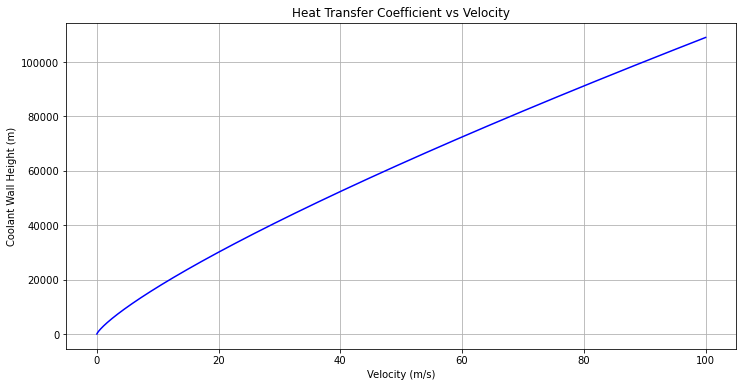

In [687]:
# plot h_coolant vs velocity
rho_c = rho_coolant_Q0_P(node0.P_c) # [kg/m^3] - coolant density at first node
Pr_c = Pr_coolant_Q0_P(node0.P_c) # [-] - coolant Prandtl number at first node
h = h_guess # [m] - initial guess for coolant wall height
v = np.linspace(0, 100, 1000) # [m/s] - velocity range to plot over
h_coolant = np.zeros_like(v) # [m] - coolant wall height at each velocity

for i, el in enumerate(v):
    h_coolant[i] = h_coolant_dittus_boelter(rho_c, el, Dh_rectangular(node0.w, h), mu_coolant, Pr_c, k_coolant) # coolant convective heat transfer coefficient at each velocity

fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(v, h_coolant, color = "b")
axs.grid()
axs.set_xlabel("Velocity (m/s)")
axs.set_ylabel("Coolant Wall Height (m)")
axs.set_title("Heat Transfer Coefficient vs Velocity")
plt.show()


In [688]:
# define function to find wall height that produces target thermal resistance R_c of coolant boundary layer
def solve_for_h(node):
    def func_to_solve(h):
        # find target thermal resistance of coolant boundary layer
        R_c_target = (node.T_cw - node.T_c) / node.Q # [K/W]

        # calculate velocity of coolant at node
        rho_c = rho_coolant_Q0_P(node.P_c) # coolant density at node [kg/m^3]
        v = o_mdot / (rho_c * node.w * N_channels * h) # coolant velocity [m/s]
        
        # solve for convective heat transfer coefficient of coolant boundary layer from height h
        h_c = h_coolant_dittus_boelter(rho_c, v, Dh_rectangular(node.w, h), mu_coolant, Pr_coolant_Q0_P(node.P_c), k_coolant)

        # solve for thermal resistance of coolant boundary layer
        R_c = R_convective(node.r + node.t_w, h_c, dx) # [K/W]

        return R_c - R_c_target # we want to minimize the difference / find the root (when the difference is zero)

    # solve for coolant wall height
    return scipy.optimize.root_scalar(func_to_solve, bracket = [0.00001, 0.1], x0 = h_guess).root # the bracket is the range of values to search for the root, x0 is the initial guess

# solve for channel height and velocity at node
h = solve_for_h(node0) # [m] - coolant wall height at first node
v_c = o_mdot / (rho_coolant_Q0_P(node0.P_c) * node0.w * N_channels * h) # coolant velocity [m/s]

# add coolant wall height and velocity to node
node0.set_h(h)
node0.set_v_c(v_c)

# validate result
R_c_target = (node0.T_cw - node0.T_c) / node0.Q # [K/W]
h_c = h_coolant_dittus_boelter(rho_coolant_Q0_P(node0.P_c), v_c, Dh_rectangular(node0.w, h), mu_coolant, Pr_coolant_Q0_P(node0.P_c), k_coolant)
R_c = R_convective(node0.r + node0.t_w, h_c, dx) # [K/W]

print("Calculated coolant wall height in cm:", h * 100.0, "[cm]", "\nTarget thermal resistance:", R_c_target, "[K/W]", "\nCalculated thermal resistance:", R_c, "[K/W]", "\nCoolant velocity:", v_c, "[m/s]")

Calculated coolant wall height in cm: 0.3532888033379544 [cm] 
Target thermal resistance: 0.12951636796869156 [K/W] 
Calculated thermal resistance: 0.129516367968692 [K/W] 
Coolant velocity: 5.040835337370684 [m/s]


#### Solve for temperautre $T_{i+1}$ at next node (Step 3).
To find the temperature at the next node we assume that all the heat at the node goes to increasing the temperature of the coolant. In such a case the following relation for the enthalpy (<em>per unit mass</em>) of the coolant holds $\dot{Q} = \dot{m} \Delta h$. Also, $\Delta h = C_p \Delta T_c$ and we can solve for the temperature change as $\Delta T  = \frac{\Delta h}{C_p} = \frac{\dot{Q}}{C_p \dot{m}}$.

In [689]:
# find temperature at next node
def T_next(node):
    return node.T_c + node.Q / (o_mdot * cp_coolant_Q0_P(node.P_c)) # [K]

nodesc[1].set_T_c(T_next(node0)) # [K] - temperature at next node

print("Temperature at current node:", node0.T_c, "[K]", "\nTemperature at next node:", nodesc[1].T_c, "[K]")

Temperature at current node: 300 [K] 
Temperature at next node: 300.3344679217842 [K]


#### Solve for pressure $P_{i+1}$ at next node (Step 4).
To find the pressure at the next node we will use the Darcy-Weisbach equation to find the pressure drop at the current node $\Delta P = \frac{1}{2}\rho f_D v^2 \frac{L}{Dh}$, where $f_D$ is the Darcy–Weisbach friction factor.

To estimate the friction factor we use a Moody diagram and assumptions for the Reynolds number $Re$ and relative roughness $\frac{\epsilon}{D}$.

We estimate the Reynolds number $Re$ from typical velocities obtained in earlier simulations to be $Re \approx 100000$.

And using the surface roughness of 3D printed Inconel 718 alloy $\epsilon \approx 15.8e-6\$ m and an average channel hydraulic diameter estimate of $Dh = \approx 3.7e-3$ m, the relative roughness is estimated to be $\frac{\epsilon}{Dh} \approx 0.0043$.

Using these values in the [Moody Chart](https://engineerexcel.com/moody-chart-calculator/) we get for the friction factor the value $f_D \approx 0.03002$.

We must note also that $L$ here is the length along the channel which is not equal to $dx$ but rather $L = \frac{dL}{dx} dx = \sqrt{1 + (\frac{dr}{dx})^2} \, dx$, where $\frac{dr}{dx}$ is the local slope of the channel.

In [690]:
# define friction factor
f_D = 0.03002 # friction factor for turbulent flow from Moody chart

# find pressure at next node
def P_next(node):
    return node.P_c - dp_darcy_weisbach(f_D, rho_coolant_Q0_P(node.P_c), node.v_c, Dh_rectangular(node.w, node.h), node.drdx, dx) # [Pa]

nodesc[1].set_P_c(P_next(node0)) # [Pa] - pressure at next node

print("Pressure at current node:", node0.P_c, "[Pa]", "\nPressure at next node:", nodesc[1].P_c, "[Pa]")

Pressure at current node: 4000000.0 [Pa] 
Pressure at next node: 3999788.486338295 [Pa]


In [691]:
# print final result at first node
print("Node 0:")
node0.print_coolant_parameters()
print("\nNode 1:")
nodesc[1].print_coolant_parameters()

Node 0:
Parameter                               | Value                
-----------------------------------------------------------------
Axial Position (x)                      | 0.28206986754961866  
Channel Width (w)                       | 0.007899172753852263 
Channel Height (h)                      | 0.0035328880333795444
Coolant Bulk Temperature (T_c)          | 300                  
Coolant Pressure (P_c)                  | 4000000.0            
Coolant Velocity (v_c)                  | 5.040835337370684    
Heat Flow through Walls (Q)             | 1544.2063666296347   
Temperature Drop along Wall (T_hw-T_cw) | 500                  
Wall Thickness (t_w)                    | 0.006542436735388365 

Node 1:
Parameter                               | Value               
----------------------------------------------------------------
Axial Position (x)                      | 0.278970198675447   
Channel Width (w)                       | 0.007551271203533616
Channel Height (h)     

#### Iterate through all nodes
Now we iterate through all nodes repeating the steps 1-4

In [692]:
# iterate through all nodes, starting at node 1, if error thrown, break loop and plot full chamber with all current results for all nodes
for i, node in enumerate(nodesc[1:-1]): # iterate from N=1 to N-2 node (node before last node)
    # note: N of node is i+1 because we start at node 1 (i=0)

    # step 1 - solve for wall thickness
    try:
        t_w = solve_for_t_w(node) # [m] - wall thickness at first node
    except ValueError as error:
        print("\nValue Error at Node:", i+1)
        node.print_coolant_parameters()
        print("Error:", error)
        break
    node.set_t_w(t_w)

    # step 2 - solve for coolant wall height and velocity
    try:
        h = solve_for_h(node) # [m] - coolant wall height at first node
    except ValueError as error:
        print("\nValue Error at Node:", i+1)
        node.print_coolant_parameters()
        print("Error:", error)
        break
    v_c = o_mdot / (rho_coolant_Q0_P(node.P_c) * node.w * N_channels * h) # coolant velocity [m/s]
    node.set_h(h)
    node.set_v_c(v_c)

    # step 3 - find temperature at next node
    nodesc[i+2].set_T_c(T_next(node)) # [K] - temperature at next node

    # step 4 - find pressure at next node
    nodesc[i+2].set_P_c(P_next(node)) # [Pa] - pressure at next node
    
    # print results
    print("\nNode", i+1, ":")
    node.print_coolant_parameters()


Node 1 :
Parameter                               | Value               
----------------------------------------------------------------
Axial Position (x)                      | 0.278970198675447   
Channel Width (w)                       | 0.007551271203533616
Channel Height (h)                      | 0.003297378786112454
Coolant Bulk Temperature (T_c)          | 300.3344679217842   
Coolant Pressure (P_c)                  | 3999788.486338295   
Coolant Velocity (v_c)                  | 5.649609025434406   
Heat Flow through Walls (Q)             | 1645.9286926944787  
Temperature Drop along Wall (T_hw-T_cw) | 500                 
Wall Thickness (t_w)                    | 0.005942060430261161

Node 2 :
Parameter                               | Value                
-----------------------------------------------------------------
Axial Position (x)                      | 0.27587052980127535  
Channel Width (w)                       | 0.007203369653214981 
Channel Height (h)         

In [693]:
# set values at final node (node N-1)
node = nodesc[-1]
try:
    t_w = solve_for_t_w(node) # [m] - wall thickness at first node
except ValueError as error:
    print("\nValue Error at Node:", i+1)
    node.print_coolant_parameters()
    print("Error:", error)
node.set_t_w(t_w)

# step 2 - solve for coolant wall height and velocity
try:
    h = solve_for_h(node) # [m] - coolant wall height at first node
    v_c = o_mdot / (rho_coolant_Q0_P(node.P_c) * node.w * N_channels * h) # coolant velocity [m/s]
    node.set_h(h)
    node.set_v_c(v_c)
except ValueError as error:
    print("\nValue Error at Node:", i+1)
    node.print_coolant_parameters()
    print("Error:", error)

Calculate Additional Parameters.

In [694]:
# calculate and set Reynolds number at each node
for node in nodesc:
    node.set_Re_c(reynolds(Dh_rectangular(node.w, node.h), node.v_c, rho_coolant_Q0_P(node.P_c), mu_coolant))

# calculate 

Plot results and save results.

In [695]:
# update wall geometry lists
x = [node.x for node in nodes[::-1]] # [m] - axial position at each node (in normal order)
r = [node.r for node in nodes[::-1]] # [m] - radius at each node (in normal order)
th = [node.t_w for node in nodesc[::-1]] # [m] - wall thickness at each node (in normal order)
# set rest of wall thickness at chamber to constant value equal to that of cooling jacket exit wall thickness
th = th + [nodesc[0].t_w for i in range(len(x) - len(th))]
           
# define function to plot chamber geometry
def plot_geometry(axs):
    axs.plot(x, r, color = "k") # upper innner wall
    axs.plot(x, -np.array(r), color = "k") # lower inner wall
    axs.plot(x, np.add(r, th), color = "k") # upper outer wall
    axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
    axs.grid()
    axs.set_xlabel("Axial Position (m)")
    axs.set_ylabel("Radius (mm)")

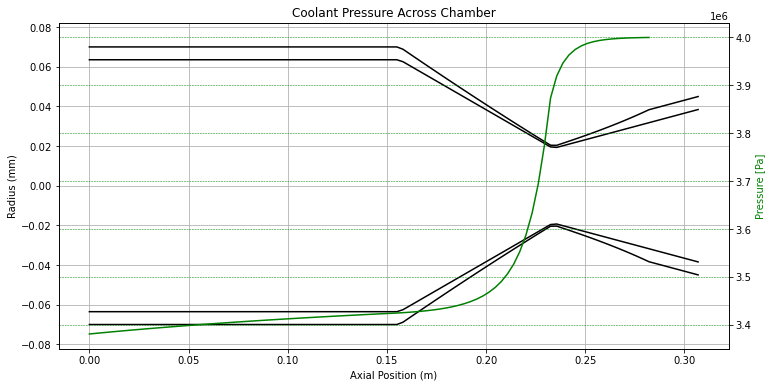

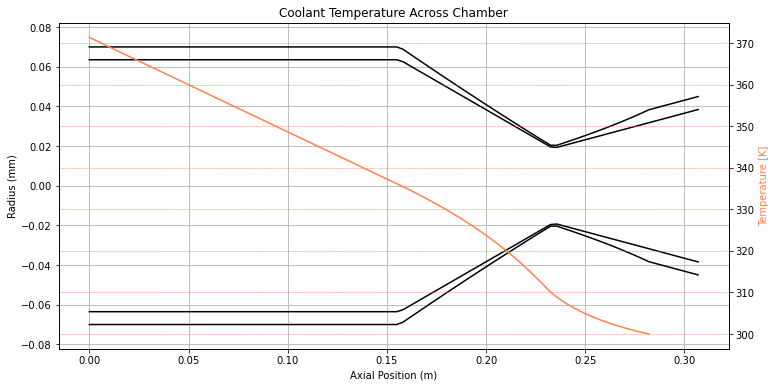

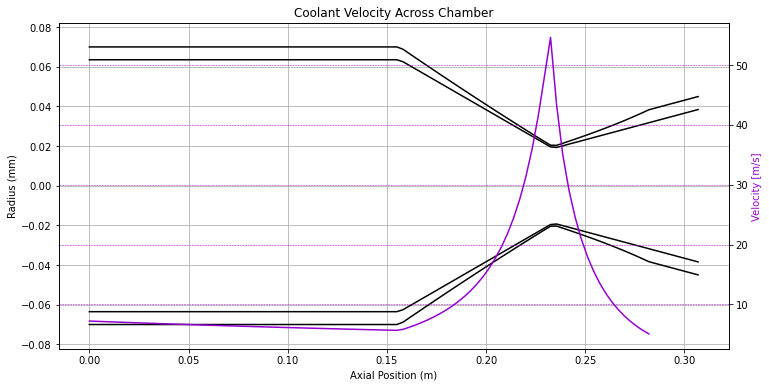

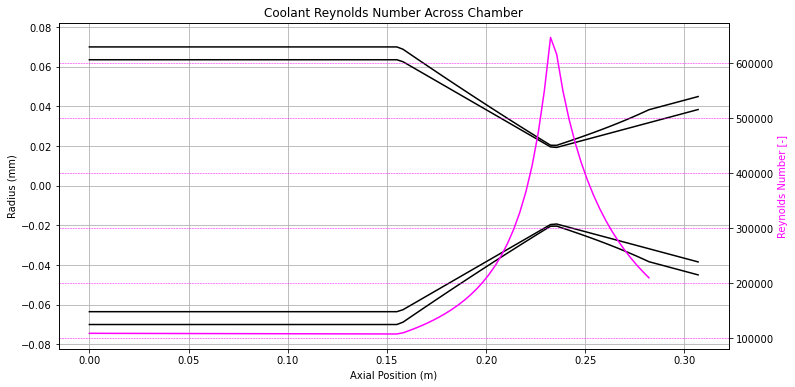

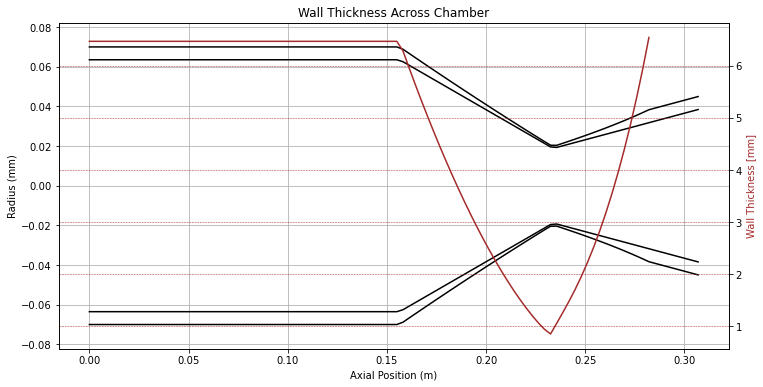

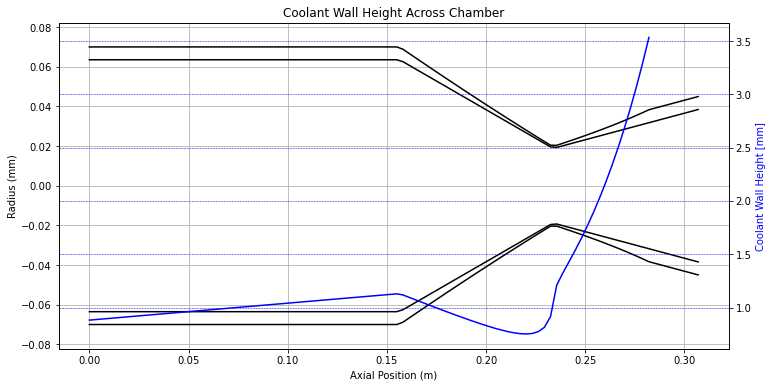

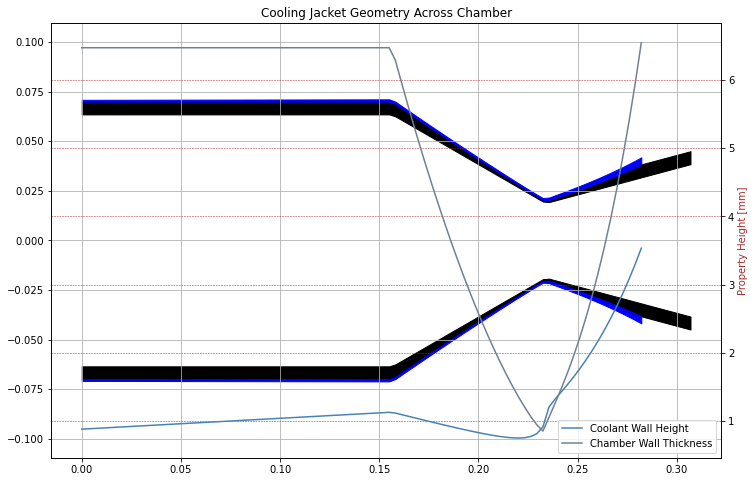

In [696]:
# plot pressure of coolant at each node on overlay of engine geometry
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
plot_geometry(axs)
axs.set_title("Coolant Pressure Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "g", linestyle = "--", linewidth = 0.5)
# plot pressure 
axs2.plot([node.x for node in nodesc], [node.P_c for node in nodesc], color = "g")
axs2.set_ylabel("Pressure [Pa]", color = "g")
plt.savefig(solvedplotfolder + "coolantpres.png", dpi=300)
plt.show()

# plot temperature of coolant at each node on overlay of engine geometry
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
plot_geometry(axs)
axs.set_title("Coolant Temperature Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "coral", linestyle = "--", linewidth = 0.5)
# plot pressure 
axs2.plot([node.x for node in nodesc], [node.T_c for node in nodesc], color = "coral")
axs2.set_ylabel("Temperature [K]", color = "coral")
plt.savefig(solvedplotfolder + "coolanttemp.png", dpi=300)
plt.show()

# plot velocity of coolant at each node on overlay of engine geometry
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
plot_geometry(axs)
axs.set_title("Coolant Velocity Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "darkviolet", linestyle = "--", linewidth = 0.5)
# plot velocity
axs2.plot([node.x for node in nodesc], [node.v_c for node in nodesc], color = "darkviolet")
axs2.set_ylabel("Velocity [m/s]", color = "darkviolet")
plt.savefig(solvedplotfolder + "coolantvel.png", dpi=300)
plt.show()

# plot Reynolds number of coolant at each node on overlay of engine geometry
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
plot_geometry(axs)
axs.set_title("Coolant Reynolds Number Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "fuchsia", linestyle = "--", linewidth = 0.5)
# plot Reynolds number
axs2.plot([node.x for node in nodesc], [node.Re_c for node in nodesc], color = "fuchsia")
axs2.set_ylabel("Reynolds Number [-]", color = "fuchsia")
plt.savefig(solvedplotfolder + "coolantreynolds.png", dpi=300)
plt.show()

# plot wall thickness of chamber at each node on overlay of engine geometry
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
plot_geometry(axs)
axs.set_title("Wall Thickness Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "brown", linestyle = "--", linewidth = 0.5)
# plot wall thickness 
axs2.plot([node.x for node in nodesc], [node.t_w * 1000 for node in nodesc], color = "brown")
axs2.set_ylabel("Wall Thickness [mm]", color = "brown")
plt.savefig(solvedplotfolder + "wallthickness.png", dpi=300)
plt.show()

# plot coolant wall height at each node on overlay of engine geometry
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
plot_geometry(axs)
axs.set_title("Coolant Wall Height Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "b", linestyle = "--", linewidth = 0.5)
# plot coolant wall height 
axs2.plot([node.x for node in nodesc], [node.h * 1000 for node in nodesc], color = "b")
axs2.set_ylabel("Coolant Wall Height [mm]", color = "b")
plt.savefig(solvedplotfolder + "coolantwallheight.png", dpi=300)
plt.show()

# plot full chamber geometry visualization
fig, axs = plt.subplots(figsize = (12, 8))
fig.set_facecolor('white')
# plot geometry walls by filling in between inner wall and outer wall
axs.fill_between(x, r, np.add(r, th), color = "k")
axs.fill_between(x, -np.array(r), np.subtract(-np.array(r), th), color = "k")
# plot coolant walls at each node on overlay by filling in between outer wall and coolant wall
axs.fill_between([node.x for node in nodesc], [node.r + node.t_w for node in nodesc], [node.r + node.t_w + node.h for node in nodesc], color = "b")
axs.fill_between([node.x for node in nodesc], [-node.r - node.t_w for node in nodesc], [-node.r - node.t_w - node.h for node in nodesc], color = "b")
axs.set_title("Cooling Jacket Geometry Across Chamber")
axs.set_aspect('equal')
axs.grid()
axs2 = axs.twinx()
axs2.grid(color = "brown", linestyle = "--", linewidth = 0.5)
# plot coolant wall height
axs2.plot([node.x for node in nodesc], [node.h * 1000 for node in nodesc], color = "steelblue", label="Coolant Wall Height")
axs2.plot([node.x for node in nodesc], [node.t_w * 1000 for node in nodesc], color = "slategray", label="Chamber Wall Thickness")
axs2.set_ylabel("Property Height [mm]", color = "brown")
plt.legend()
plt.savefig(solvedplotfolder + "fullchamber.png", dpi=300)
plt.show()

Additional Plots

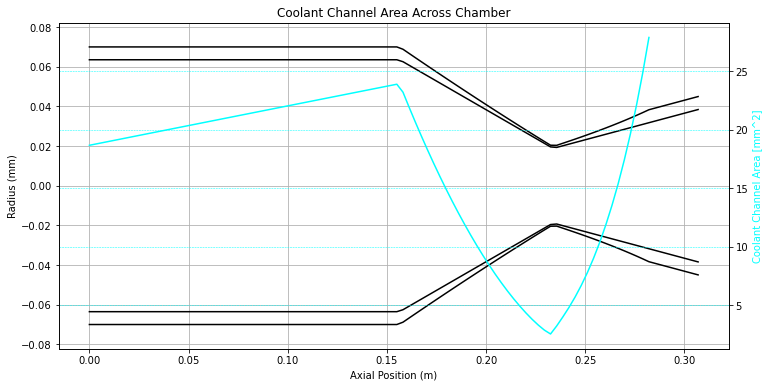

Text(0, 0.5, 'Coolant Hydraulic Diameter [mm]')

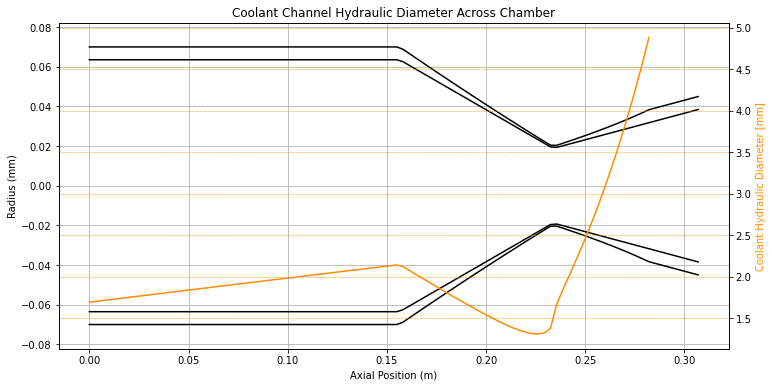

In [697]:
def plot_geometry(axs):
    axs.plot(x, r, color = "k") # upper innner wall
    axs.plot(x, -np.array(r), color = "k") # lower inner wall
    axs.plot(x, np.add(r, th), color = "k") # upper outer wall
    axs.plot(x, np.subtract(-np.array(r), th), color = "k") # lower outer wall
    axs.grid()
    axs.set_xlabel("Axial Position (m)")
    axs.set_ylabel("Radius (mm)")

# plot coolant channel area at each node on overlay of engine geometry
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
plot_geometry(axs)
axs.set_title("Coolant Channel Area Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "aqua", linestyle = "--", linewidth = 0.5)
# plot coolant channel area
axs2.plot([node.x for node in nodesc], [node.A_c * 1000000 for node in nodesc], color = "aqua")
axs2.set_ylabel("Coolant Channel Area [mm^2]", color = "aqua")
plt.show()

# plot coolant hydraulic diameter at each node on overlay of engine geometry
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
plot_geometry(axs)
axs.set_title("Coolant Channel Hydraulic Diameter Across Chamber")
axs.set_aspect('equal')
axs2 = axs.twinx()
axs2.grid(color = "darkorange", linestyle = "--", linewidth = 0.5)
# plot hydraulic diameter
axs2.plot([node.x for node in nodesc], [node.Dh_c * 1000 for node in nodesc], color = "darkorange")
axs2.set_ylabel("Coolant Hydraulic Diameter [mm]", color = "darkorange")


### Export Relevant Data to CSV files

In [698]:
# use pandas t export Mach number, temperature, and pressure data to csv
nodedf = pd.DataFrame({"x [m]": x_n, "r [m]": r_n, "M [-]": [node.M for node in nodes], "T [K]": [node.T for node in nodes], "P [Pa]": [node.P for node in nodes]})

# export to csv
nodedf.to_csv("enginefiles/nodedata.csv")

### Export Relevant Data to Excel Files

In [699]:
# get lists of node position coolant pressure, temperature, velocity, channel height, and wall thickness
x = [node.x for node in nodesc]
r = [node.r for node in nodesc]
P_c = [node.P_c for node in nodesc]
T_c = [node.T_c for node in nodesc]
v_c = [node.v_c for node in nodesc]
h = [node.h for node in nodesc]
t_w = [node.t_w for node in nodesc]

# make dataframe and save it to excel file
df = pd.DataFrame({"Axial Position of Node [m]": x, "Radius at Node [m]": r, "Coolant Pressure [Pa]": P_c, "Coolant Temperature [K]": T_c, "Coolant Velocity [m/s]": v_c, "Channel Height [m]": h, "Wall Thickness [m]": t_w})
df.to_excel("enginefiles/solverdata.xlsx", index = True)

#### Appendix A
Illustration of the nature of equation $r_A(M) = \frac{A}{A_t} = \frac{1}{M}(\frac{2+(k-1)M^2}{k+1})^{\frac{k+1}{2(k-1)}}$.

Plotting $r_A(M)$ for different $M$ values. (<em>Horizontal line of expansion ratio $A_e/A_t$ shown</em>). From the following grap it is clear to see that for a given $A$ (<em>or more precisely $\frac{A}{A_t}$</em>) there are 2 solutions to $M$.

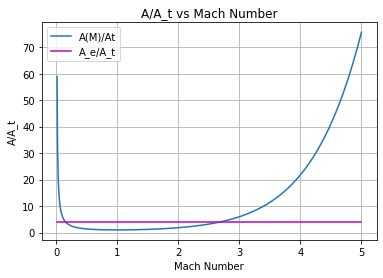

In [700]:
# plot A_At vs M varying M from 1e-2 to 5
# also plat horizontal line of A_e/A_t
fig, axs = plt.subplots()
fig.set_facecolor('white')
M = np.linspace(1e-2, 5, 1000)
axs.plot(M, A_At(M, kc), label = "A(M)/At")
axs.plot(M, A_e/A_t * np.ones(len(M)), color = "m", label = "A_e/A_t")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A/A_t")
axs.set_title("A/A_t vs Mach Number")
plt.legend()
plt.show()

The way we find particular solutions is to find the points (the Mach numbers $M$ on the horizontal axis) where the difference between our area ratio in question $\frac{A}{A_t}$ and that given by the equation $r_A(M)$ is zero (<em>i.e. find the $M$ values that solve $r_A(M) = \frac{A}{A_t}$</em>).

The plots of the <em>error</em> / <em>difference</em> function $\frac{A_e}{A_t} - r_A(M)$ for a particular area (<em> exit area $A_e$</em>) for which we numerically find a root is given below in both the subsonic and supersonic regions.

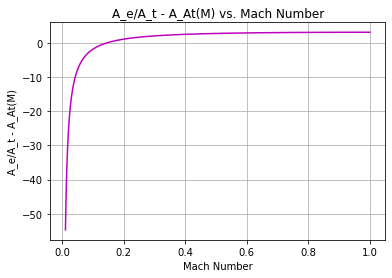

In [701]:
# plot A_e/A_t - A_At() varying M - subsonic region
fig, axs = plt.subplots()
fig.set_facecolor('white')
Mlist = np.linspace(1e-2, 1, 1000)
r_A = np.array([A_e/A_t - A_At(M, kc) for M in Mlist])
axs.plot(Mlist, r_A, color = "m")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A_e/A_t - A_At(M)")
axs.set_title("A_e/A_t - A_At(M) vs. Mach Number")
plt.show()


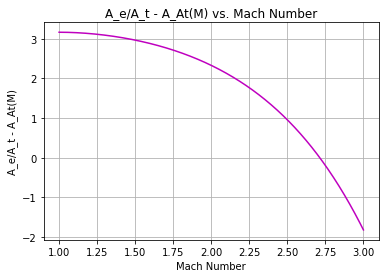

In [702]:
# plot A_e/A_t - A_At() varying M - supersonic region
fig, axs = plt.subplots()
fig.set_facecolor('white')
Mlist = np.linspace(1, 3, 1000)
r_A = np.array([A_e/A_t - A_At(M, kc) for M in Mlist])
axs.plot(Mlist, r_A, color = "m")
axs.grid()
axs.set_xlabel("Mach Number")
axs.set_ylabel("A_e/A_t - A_At(M)")
axs.set_title("A_e/A_t - A_At(M) vs. Mach Number")
plt.show()